In [82]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from keras.utils import load_img, img_to_array
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

In [76]:
#(train, test), metadata = tfds.load('domainnet/quickdraw', split=['train', 'test'], with_info=True)
train, _ = tfds.load('domainnet/quickdraw', split=['train', 'test'], with_info=True, as_supervised=True)

In [120]:
# Гиперпараметры
batch_size = 64
# 10 категорий для изображений  (CIFAR-10)
num_classes = 345
# количество эпох для обучения
epochs = 10

In [93]:
def load_data():
    def preprocess_image(image, label):
        # преобразуем целочисленный диапазон [0, 255] в диапазон действительных чисел [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image, label
    # загружаем набор данных CIFAR-10, разделяем его на обучающий и тестовый
    ds_train, info = tfds.load("cifar10", with_info=True, split="train", as_supervised=True)
    ds_test = tfds.load("cifar10", split="test", as_supervised=True)
    # повторять набор данных, перемешивая, предварительно обрабатывая, разделяем по пакетам
    ds_train = ds_train.repeat().shuffle(1024).map(preprocess_image).batch(batch_size)
    ds_test = ds_test.repeat().shuffle(1024).map(preprocess_image).batch(batch_size)
    return ds_train, ds_test, info

In [94]:
def create_model(input_shape):
    # построение модели
    model = tf.keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # сглаживание неровностей
    model.add(Flatten())
    # полносвязный слой
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    # печатаем итоговую архитектуру модели
    model.summary()
    # обучение модели с помощью оптимизатора Адама
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [121]:
# загружаем данные
ds_train, ds_test, info = load_data()
# конструируем модель
model = create_model(input_shape=info.features["image"].shape)
# обучаем
model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=1,
          steps_per_epoch=info.splits["train"].num_examples // batch_size,
          validation_steps=info.splits["test"].num_examples // batch_size)
# сохраняем модель на диске
model.save("results/cifar10-model-v1.h5")

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_32 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 activation_33 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 16, 16, 32)        0         
                                                     

KeyboardInterrupt: 

ссылка на датасет

https://www.tensorflow.org/datasets/catalog/cifar10



In [96]:
categories = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [98]:
from keras.models import load_model
# загрузим тестовый набор
ds_train, ds_test, info = load_data()
# загрузим итоговую модель с весовыми коэффициентами
model = load_model("results/cifar10-model-v1.h5")

In [100]:
print(ds_test)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


1/1 [==============================] - 0s 24ms/step
Predicted label: truck
True label: truck


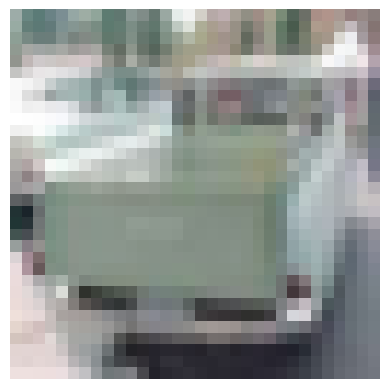

1/1 [==============================] - 0s 23ms/step
Predicted label: dog
True label: bird


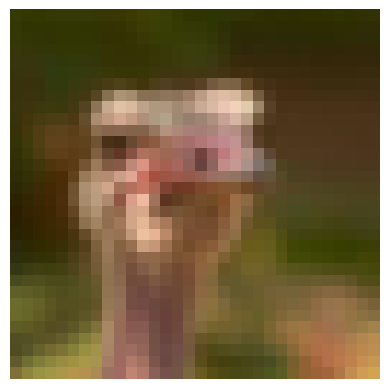

1/1 [==============================] - 0s 23ms/step
Predicted label: horse
True label: horse


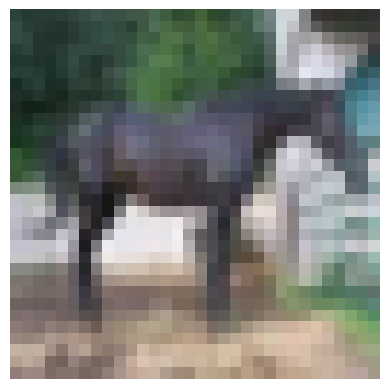

1/1 [==============================] - 0s 24ms/step
Predicted label: bird
True label: deer


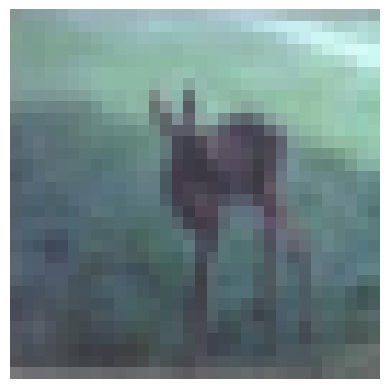

1/1 [==============================] - 0s 23ms/step
Predicted label: dog
True label: bird


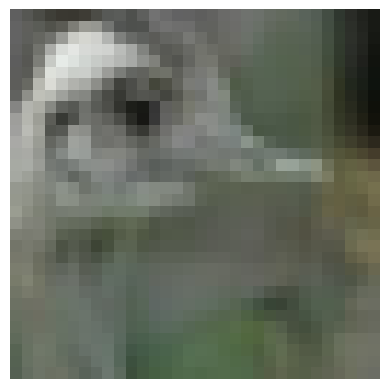

1/1 [==============================] - 0s 24ms/step
Predicted label: bird
True label: bird


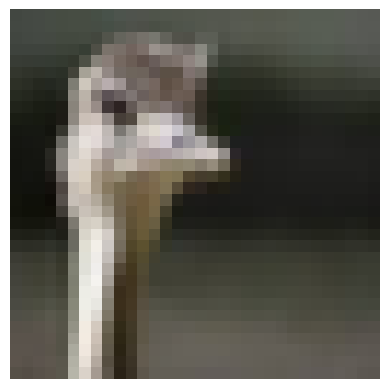

1/1 [==============================] - 0s 24ms/step
Predicted label: cat
True label: dog


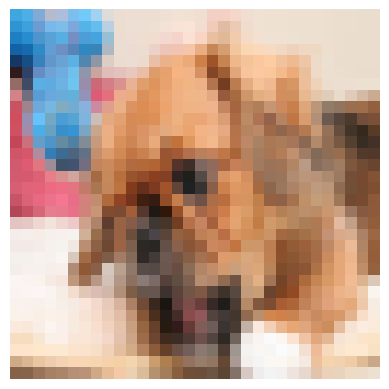

1/1 [==============================] - 0s 23ms/step
Predicted label: horse
True label: dog


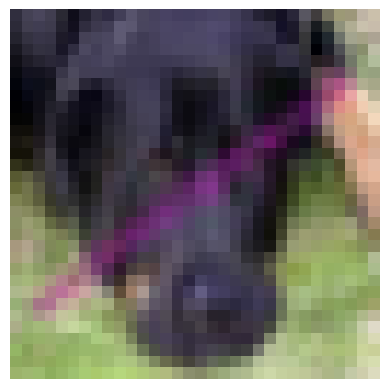

1/1 [==============================] - 0s 24ms/step
Predicted label: dog
True label: dog


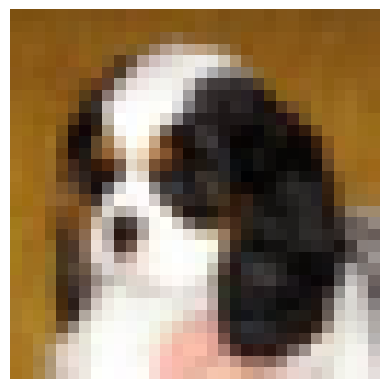

1/1 [==============================] - 0s 24ms/step
Predicted label: dog
True label: horse


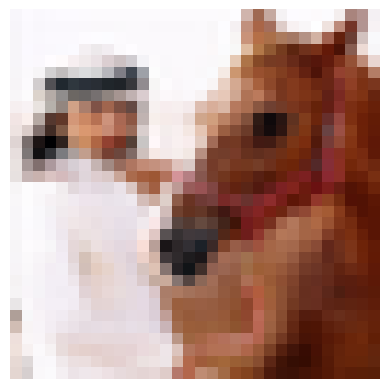

In [108]:
for i in range(10):
    # получить прогноз для этого изображения
    data_sample = next(iter(ds_test))
    sample_image = data_sample[0].numpy()[0]
    sample_label = categories[data_sample[1].numpy()[0]]
    prediction = np.argmax(model.predict(sample_image.reshape(-1, *sample_image.shape))[0])
    print("Predicted label:", categories[prediction])
    print("True label:", sample_label)
    plt.axis('off')
    plt.imshow(sample_image)
    plt.show()

In [109]:
SIZE = 32
def resize_image(img, label):
  img = tf.cast(img, tf.float32)
  img = tf.image.resize(img, (SIZE, SIZE))
  img = img / 255.0
  return img, label

1/1 [==============================] - 0s 23ms/step
0
Predicted label: airplane


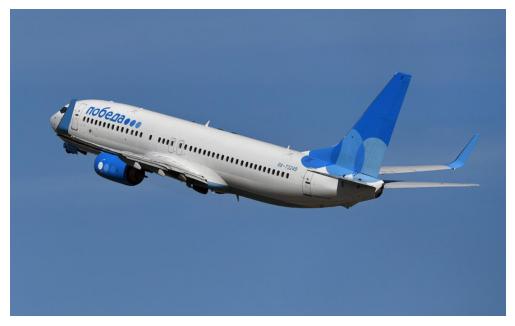

1/1 [==============================] - 0s 23ms/step
0
Predicted label: airplane


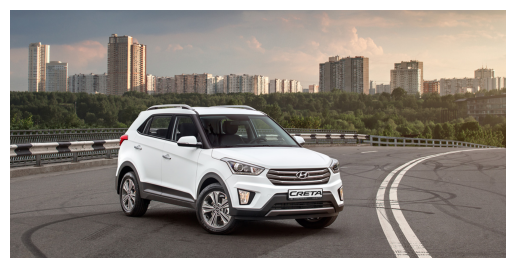

1/1 [==============================] - 0s 23ms/step
0
Predicted label: airplane


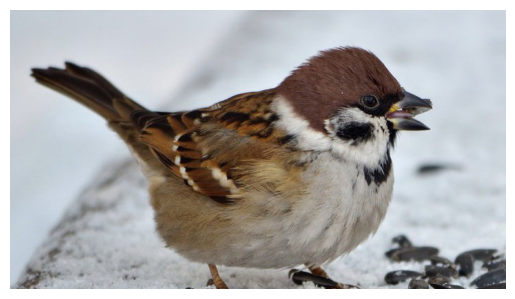

1/1 [==============================] - 0s 22ms/step
4
Predicted label: deer


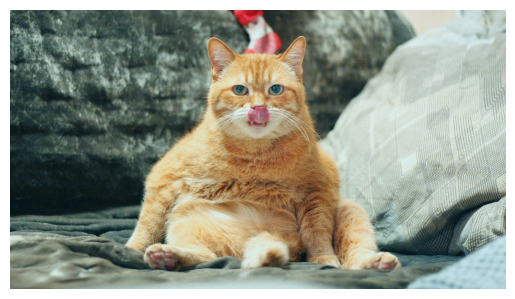

1/1 [==============================] - 0s 24ms/step
2
Predicted label: bird


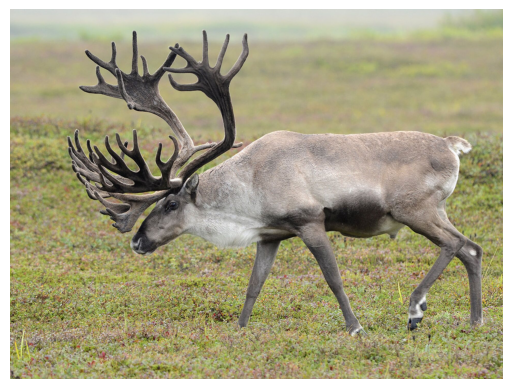

1/1 [==============================] - 0s 22ms/step
4
Predicted label: deer


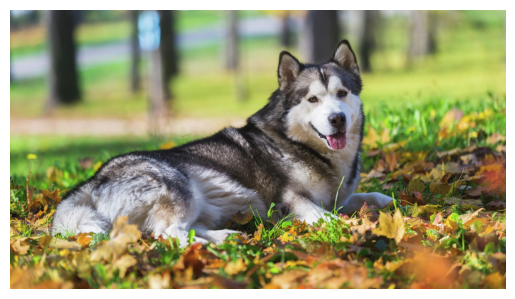

1/1 [==============================] - 0s 24ms/step
6
Predicted label: frog


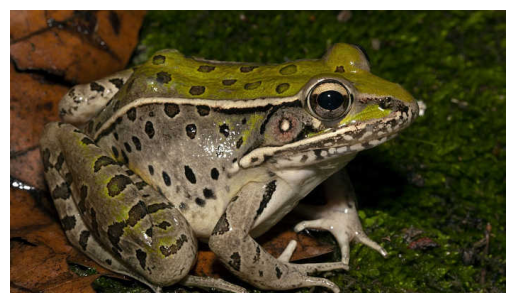

1/1 [==============================] - 0s 23ms/step
7
Predicted label: horse


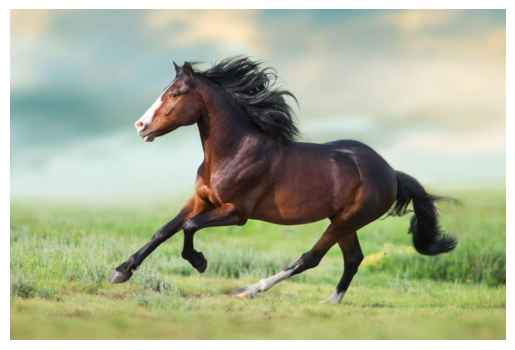

1/1 [==============================] - 0s 25ms/step
8
Predicted label: ship


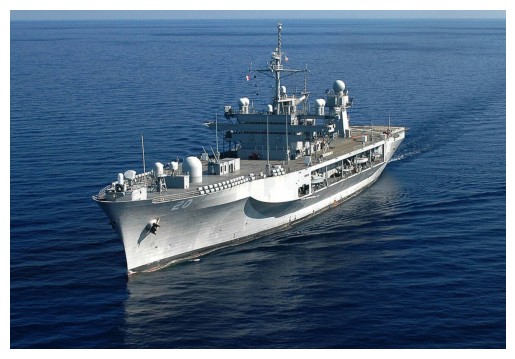

1/1 [==============================] - 0s 26ms/step
9
Predicted label: truck


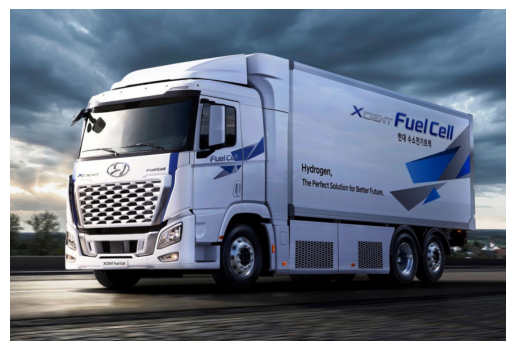

In [119]:
for i in range(10):
    img = load_img(f'img\\{i}.jpg')
    img_array = img_to_array(img)
    img_resized, _ = resize_image(img_array, _)
    img_expended = np.expand_dims(img_resized, axis=0)
    prediction = model.predict(img_expended)[0]
    prediction = np.argmax(model.predict(img_expended)[0])
    print(prediction)
    print("Predicted label:", categories[prediction])
    plt.axis('off')
    plt.imshow(img)
    plt.show()